<a href="https://colab.research.google.com/github/Ndy-S/machine-learning-fundamental/blob/main/Natural%20Language%20Processing%20with%20Attention%20Models/W2_text_summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Summarization

## Transformers vs RNNs
### Outline
- Issues with RNNs
- Comparison with Transformers

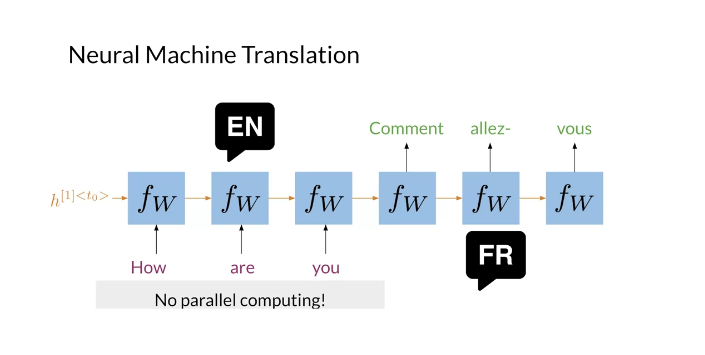

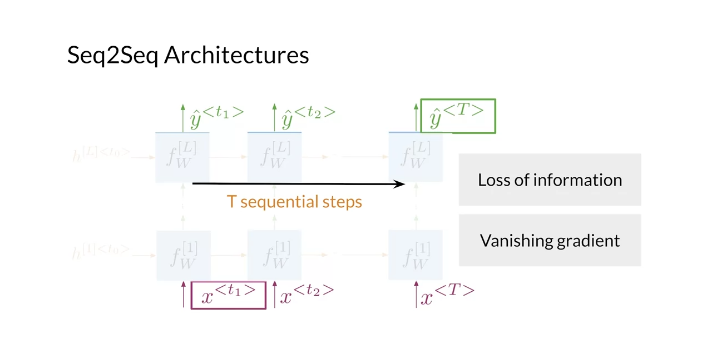

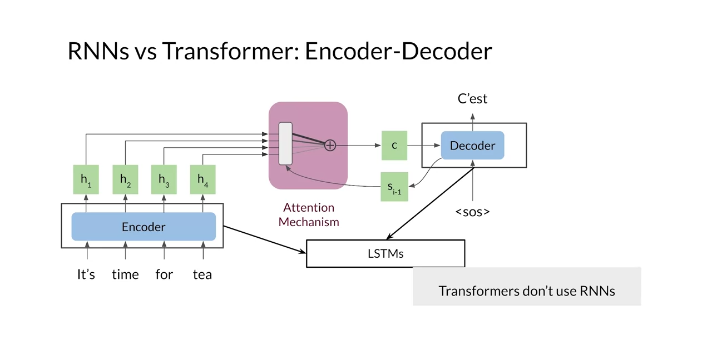

In [1]:
# SECTION DIVIDER

## Transformers overview

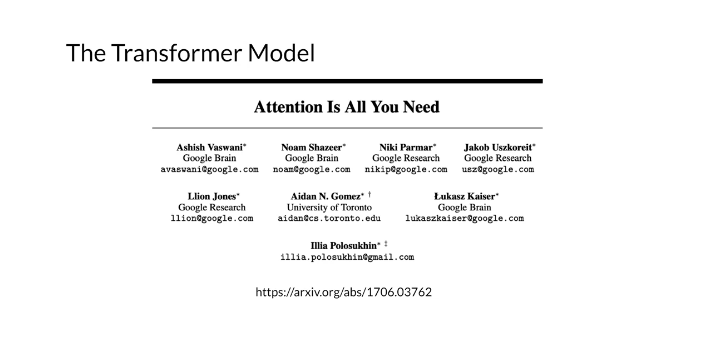

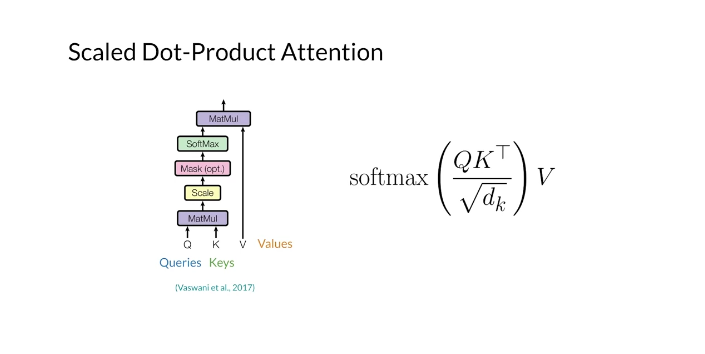

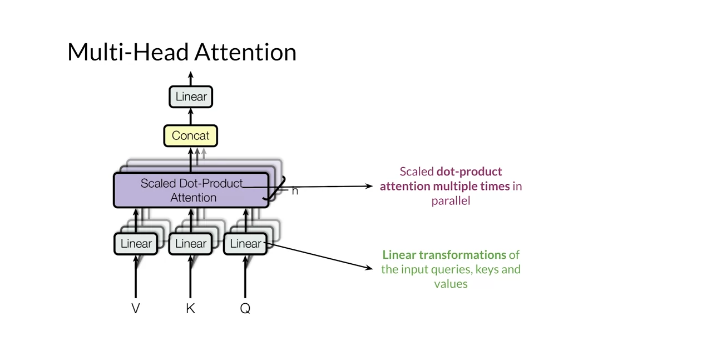

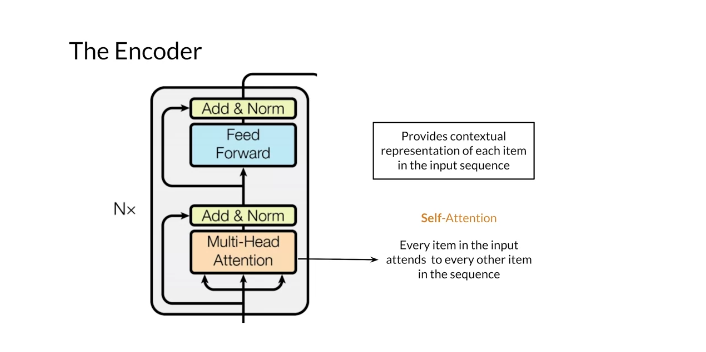

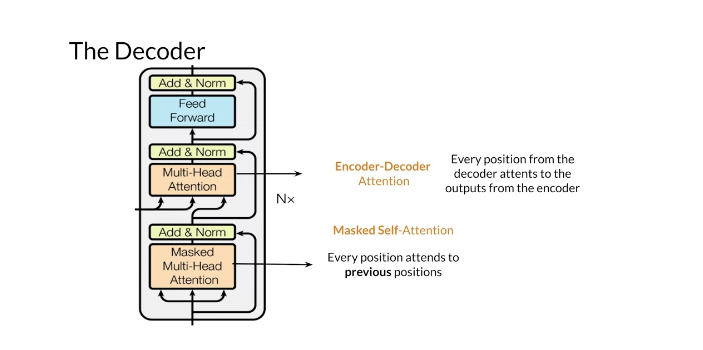

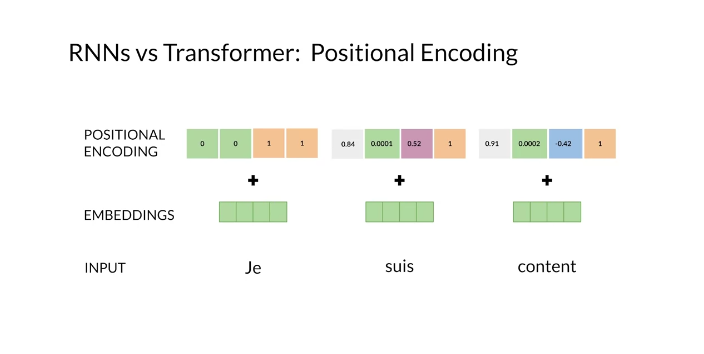

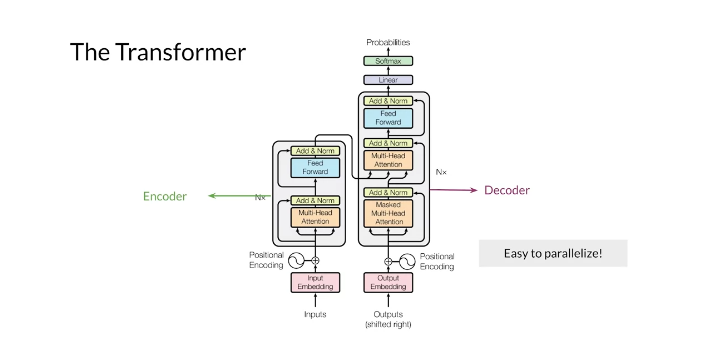

### Summary
- In RNNs parallel computing is difficult to implement
- For long sequences in RNNs there is loss of information
- In RNNs there is the problem of vanishing gradient
- Transformers help with all of the above

In [2]:
# SECTION DIVIDER

## Transformer Applications
### Outline
- Transformers applications in NLP
- Some Transformers
- Introduction to T5

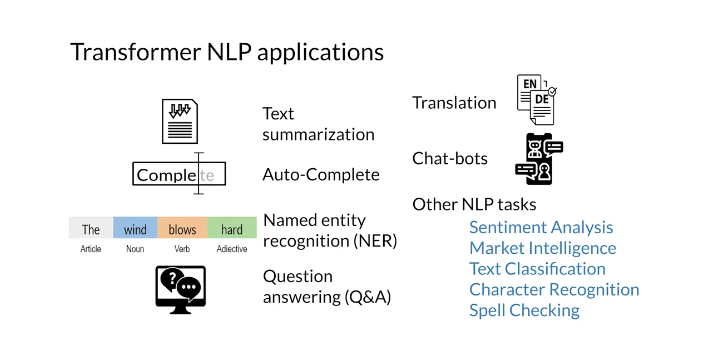

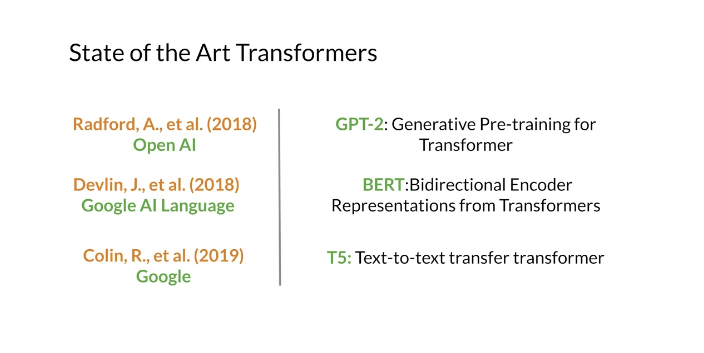

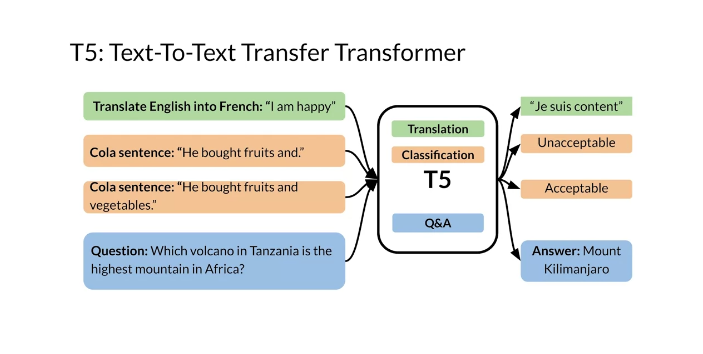

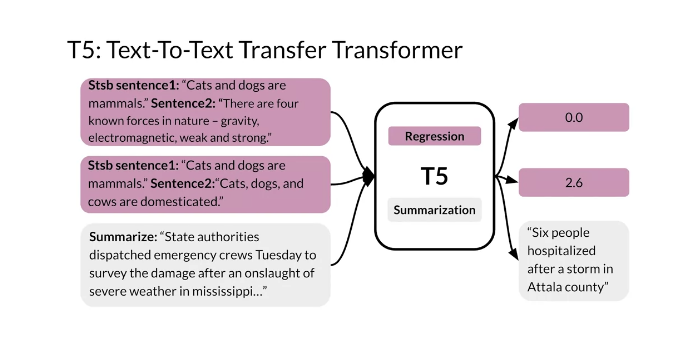

### Summary
- Transformers are suitable for a wide range of NLP applications
- GPT-2, BERT and T5 are the cutting-edge Transformers
- T5 is a powerful multi-task transformer

In [3]:
# SECTION DIVIDER

## Scaled and Dot-Product Attention
### Outline
- Revisit scaled dot product attention
- Mathematics behind Attention

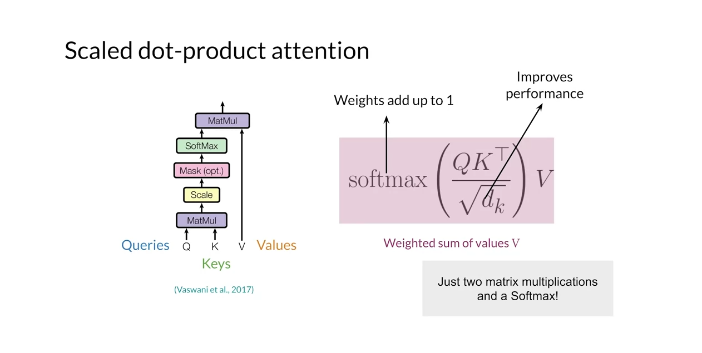

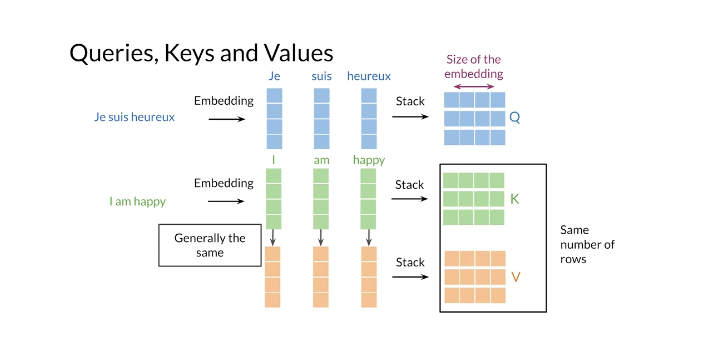

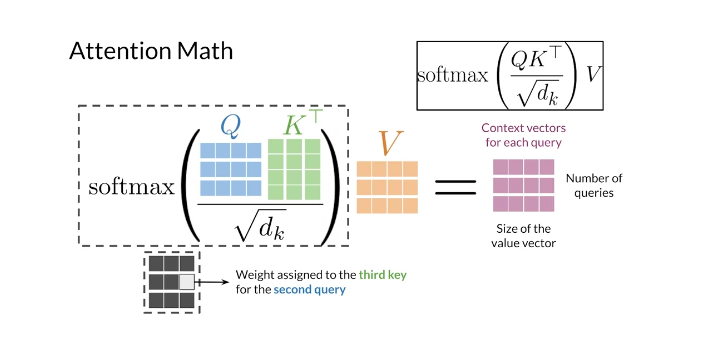

### Summary
- Scaled Dot-product Attention is essential for Transformer
- The input to Attention are queries, keys, and values
- GPUs and TPUs

In [4]:
# SECTION DIVIDER

## Masked Self Attention
### Outline
- Ways of Attention
- Overview of masked Self-Attention

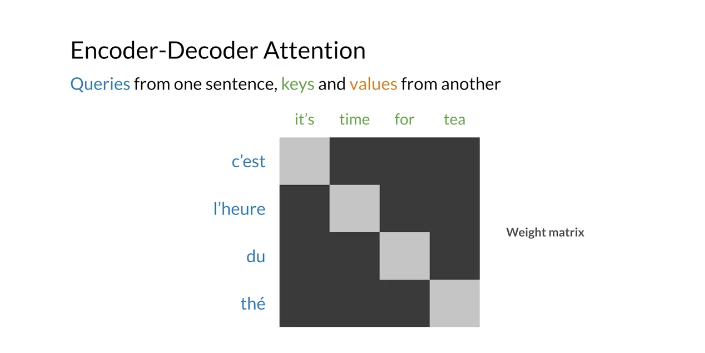

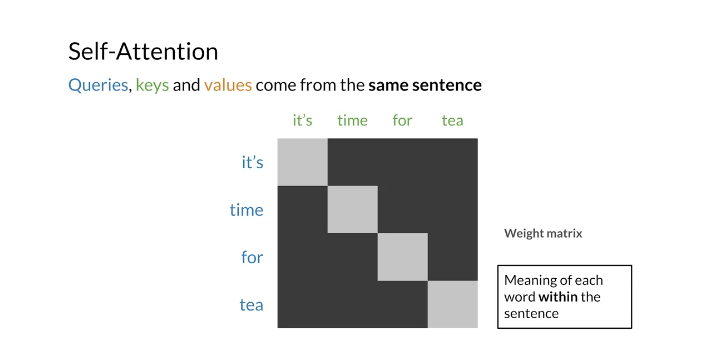

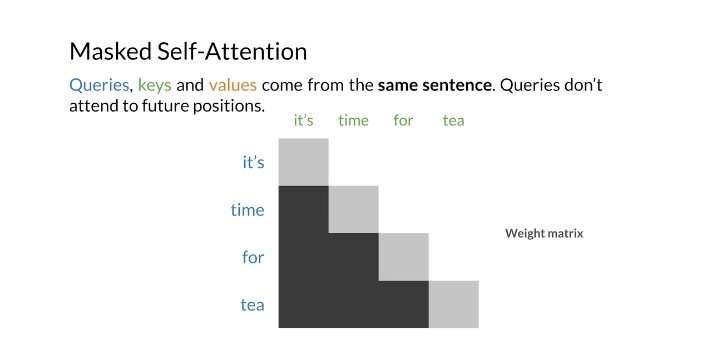

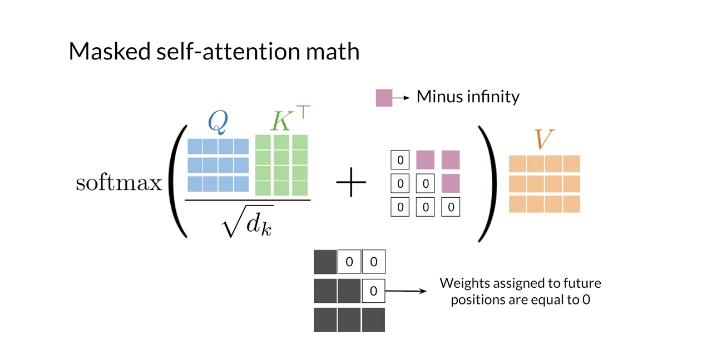

### Summary
- There are three main ways of Attention: Encoder/Decoder, self-attention and masked self-attention.
- In self-attention, queries and keys come from the same sentence
- In masked self-attention queries cannot attend to the future

In [5]:
# SECTION DIVIDER

## Multi-head Attention
### Outline
- Intuition Multi-Head Attention
- Math of Multi-Head Attention

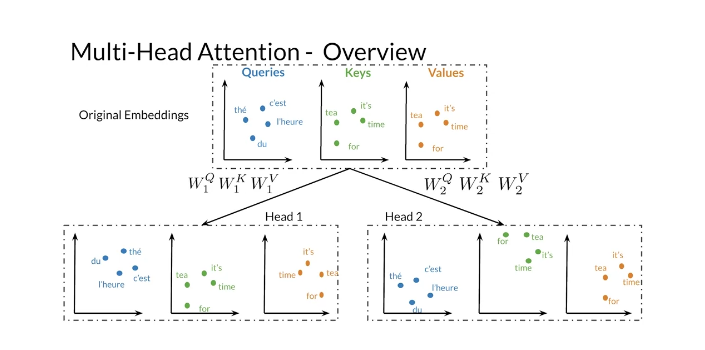

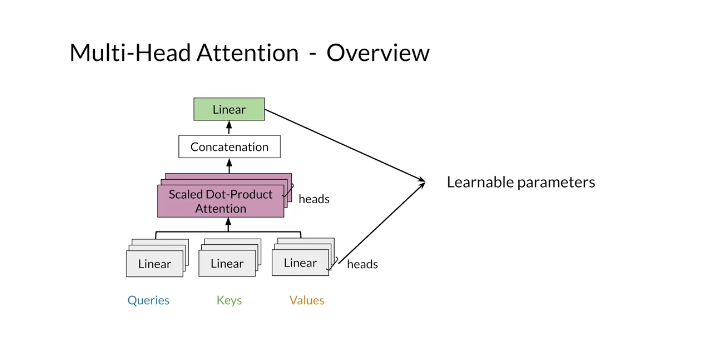

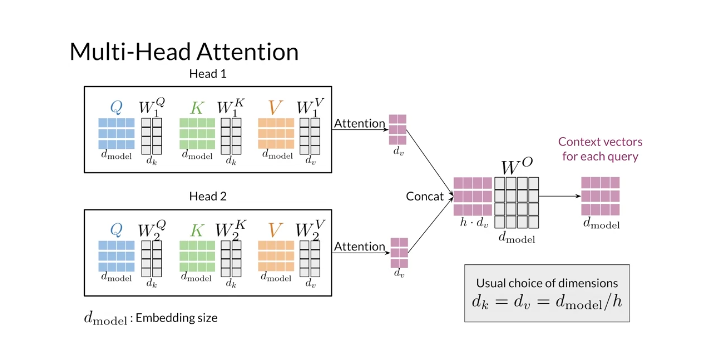

### Summary
- Multi-Headed models attend to information from different representations
- Parallel computations
- Similar computational cost to single-head attention

In [6]:
# SECTION DIVIDER

## Attention Code

In [8]:
import sys
import numpy as np
import scipy.special
import textwrap
wrapper = textwrap.TextWrapper(width=70)

# to print the entire np array
np.set_printoptions(threshold=sys.maxsize)

In [11]:
# Helper functions
def create_tensor(t):
  return np.array(t)

def display_tensor(t, name):
  print(f"{name} shape: {t.shape}")
  print(f"{t}\n")

In [13]:
q = create_tensor([[1, 0, 0], [0, 1, 0]])
display_tensor(q, 'query')
k = create_tensor([[1, 2, 3], [4, 5, 6]])
display_tensor(k, 'key')
v = create_tensor([[0, 1, 0], [1, 0, 1]])
display_tensor(v, 'value')
m = create_tensor([[0, -1e9], [0, 0]])
display_tensor(m, 'mask')

query shape: (2, 3)
[[1 0 0]
 [0 1 0]]

key shape: (2, 3)
[[1 2 3]
 [4 5 6]]

value shape: (2, 3)
[[0 1 0]
 [1 0 1]]

mask shape: (2, 2)
[[ 0.e+00 -1.e+09]
 [ 0.e+00  0.e+00]]



In [30]:
# Dot product attention
def DotProductAttention(query, key, value, mask, scale=True):
  assert query.shape[-1] == key.shape[-1] == value.shape[-1], "Embedding dimensions of q, k, v aren't all the same"

  if scale:
    depth = query.shape[-1]
  else:
    depth = 1

  dots = np.matmul(query, np.swapaxes(key, -1, -2)) / np.sqrt(depth)

  if mask is not None:
    dots = np.where(mask, dots, np.full_like(dots, -1e9))

  logsumexp = scipy.special.logsumexp(dots, axis=-1, keepdims=True)
  dots = np.exp(dots - logsumexp)
  attention = np.matmul(dots, value)

  return attention


In [31]:
def dot_product_self_attention(q, k, v, scale=True):
  mask_size = q.shape[-2]
  mask = np.tril(np.ones((1, mask_size, mask_size), dtype=np.bool_), k=0)

  return DotProductAttention(q, k, v, mask, scale=scale)

In [32]:
dot_product_self_attention(q, k, v)

array([[[0.        , 1.        , 0.        ],
        [0.84967455, 0.15032545, 0.84967455]]])

In [28]:
# SECTION DIVIDER

## Transformer Decoder
### Overview
- Overview of Transformer decoder
- Implementation (decoder and feed-forward block)

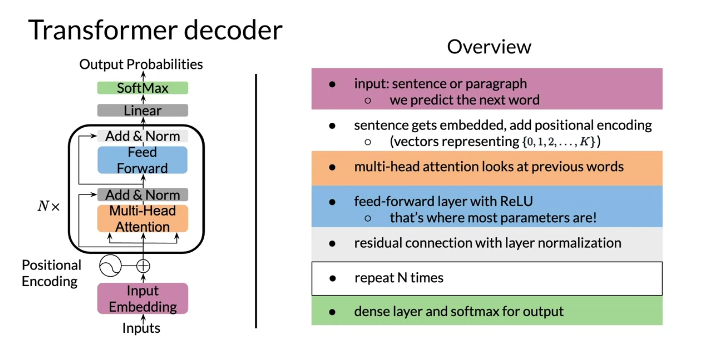

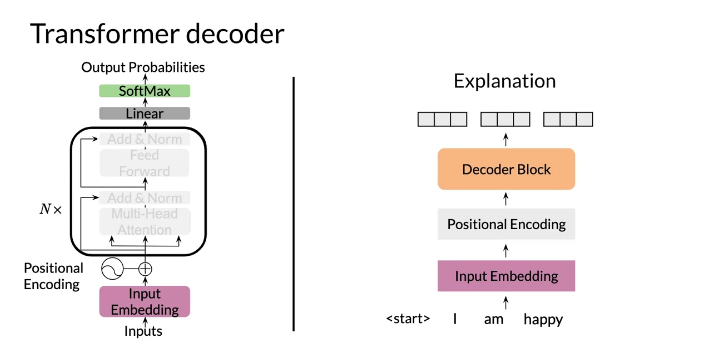

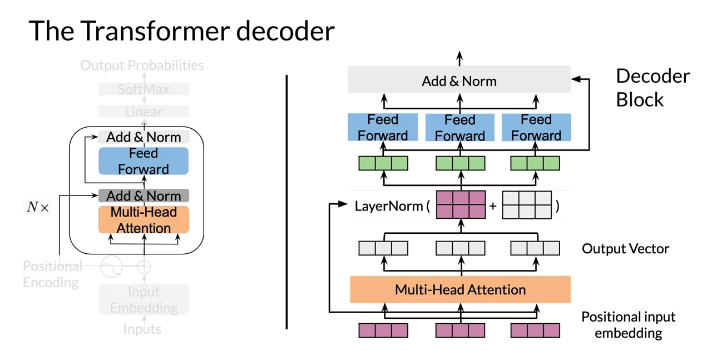

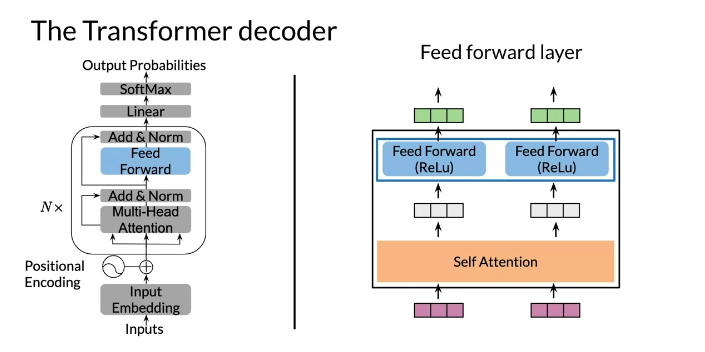

### Summary
- Transformer decoder mainly consists of three layers
- Decoder and feed-forward blocks are the core of this model code
- It also includes a module to calculate the cross-entropy loss

In [33]:
# SECTION DIVIDER

## Transformer Summarizer
### Outline
- Overview of Transformer summarizer
- Technical details for data processing
- Inference with a Language Model

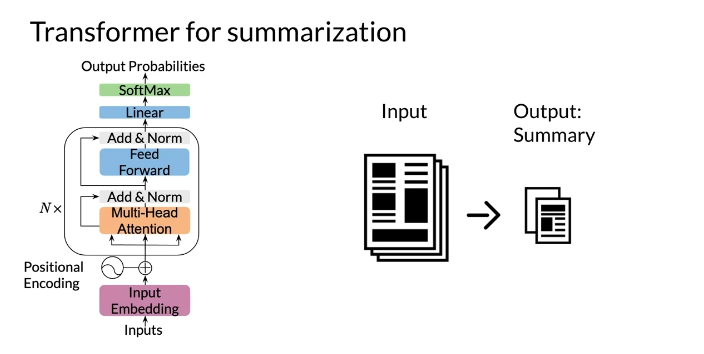

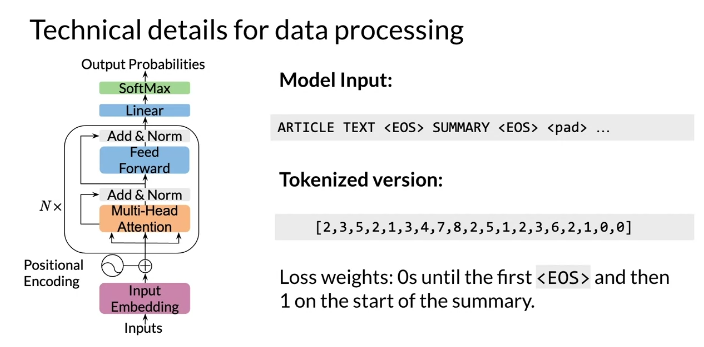

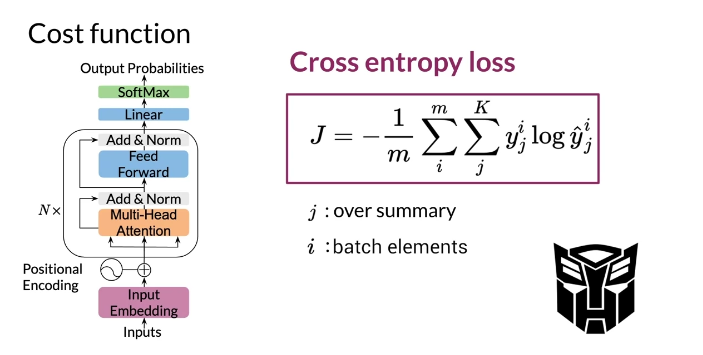

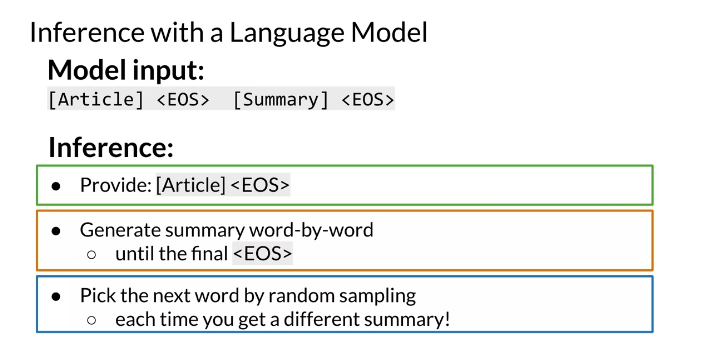

### Summary
- For summarization, a weighted loss function is optimized
- Transformer Decoder summarizes predicting the next word using
- The transformer uses tokenized versions of the input

In [34]:
# SECTION DIVIDER

## The Transformer Decoder Code

In [35]:
!pip install trax
from IPython.display import clear_output
clear_output(wait=False)

In [36]:
import sys
import os
import time
import numpy as np
import gin
import textwrap
wrapper = textwrap.TextWrapper(width=70)
import trax
from trax import layers as tl
from trax.fastmath import numpy as jnp

# to print the entire np array
np.set_printoptions(threshold=sys.maxsize)

In [37]:
# Sentence gets embedded, add positional encoding
def PositionalEncoder(vocab_size, d_model, dropout, max_len, mode):
  return [
      tl.Embedding(vocab_size, d_model),
      tl.Dropout(rate=dropout, mode=mode),
      tl.PositionalEncoding(max_len=max_len, mode=mode)
  ]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [38]:
# Feed-forward layer
def FeedForward(d_model, d_ff, dropout, mode, ff_activation):
  return [
      tl.LayerNorm(),
      tl.Dense(d_ff),
      ff_activation(),
      tl.Dropout(rate=dropout, mode=mode),
      tl.Dense(d_model),
      tl.Dropout(rate=dropout, mode=mode)
  ]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [39]:
# Decoder block
def DecoderBlock(d_model, d_ff, n_heads, dropout, mode, ff_activation):
  return [
      tl.Residual(
          tl.LayerNorm(),
          tl.CasualAttention(d_model, n_heads=n_heads, dropout=dropout, mode=mode)
      ),
      tl.Residual(
          FeedForward(d_model, d_ff, dropout, mode, ff_activation)
      )
  ]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [40]:
# The transformer decoder: putting it all together
def TransformerLM(vocab_size=33300,
                  d_model=512,
                  d_ff=2048,
                  n_layers=6,
                  n_heads=8,
                  dropout=0.1,
                  max_len=4096,
                  mode='train',
                  ff_activation=tl.Relu):
  decoder_blocks = [DecoderBlock(d_model, d_ff, n_heads, dropout, mode, ff_activation) for _ in range(n_layers)]
  return tl.Serial(
      tl.ShiftRight(mode=mode),
      PositionalEncoder(vocab_size, d_model, dropout, max_len, mode),
      decoder_blocks,
      tl.LayerNorm(),
      tl.Dense(vocab_size),
      tl.LogSoftmax()
  )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [43]:
# SECTION DIVIDER

## Transformer Summarizer